In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

In [5]:
iris_data = load_iris()

iris_df = pd.DataFrame(
    data=iris_data.data,
    columns=iris_data.feature_names
)

iris_df['target'] = iris_data.target

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


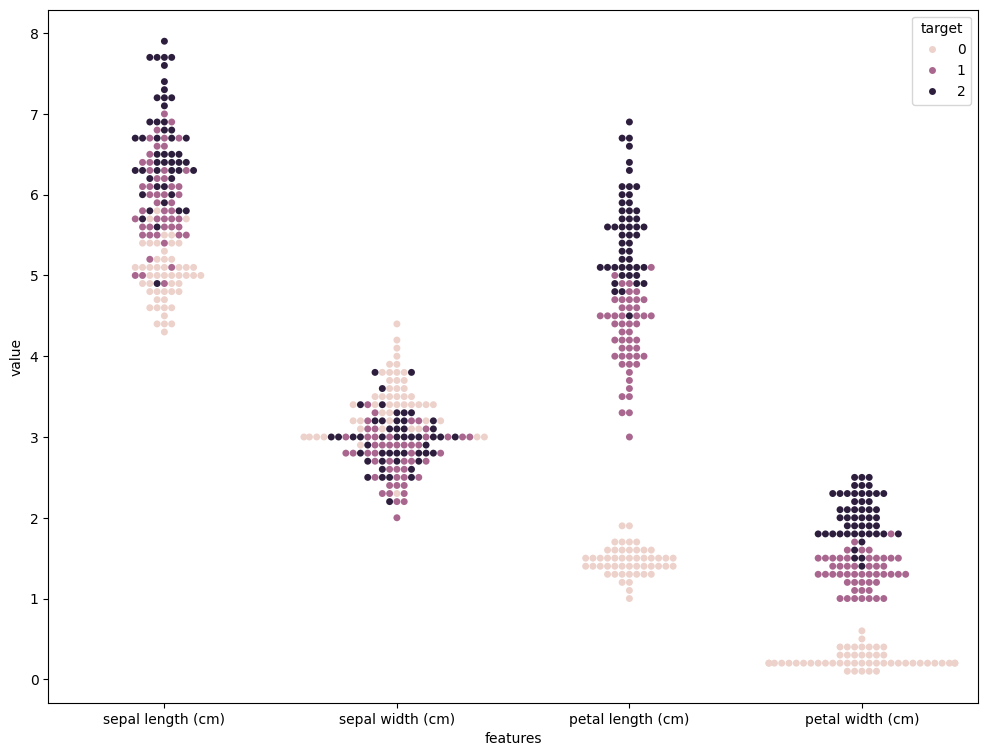

In [6]:
from seaborn import swarmplot

# Data preparation for visualization
data_to_plot = pd.melt(iris_df,
                       id_vars='target',
                       var_name='features',
                       value_name='value')

swarmplot(data=data_to_plot, x='features', y='value', hue='target');


In [7]:
iris_df['target'].value_counts()

,count
target,
0,50
1,50
2,50


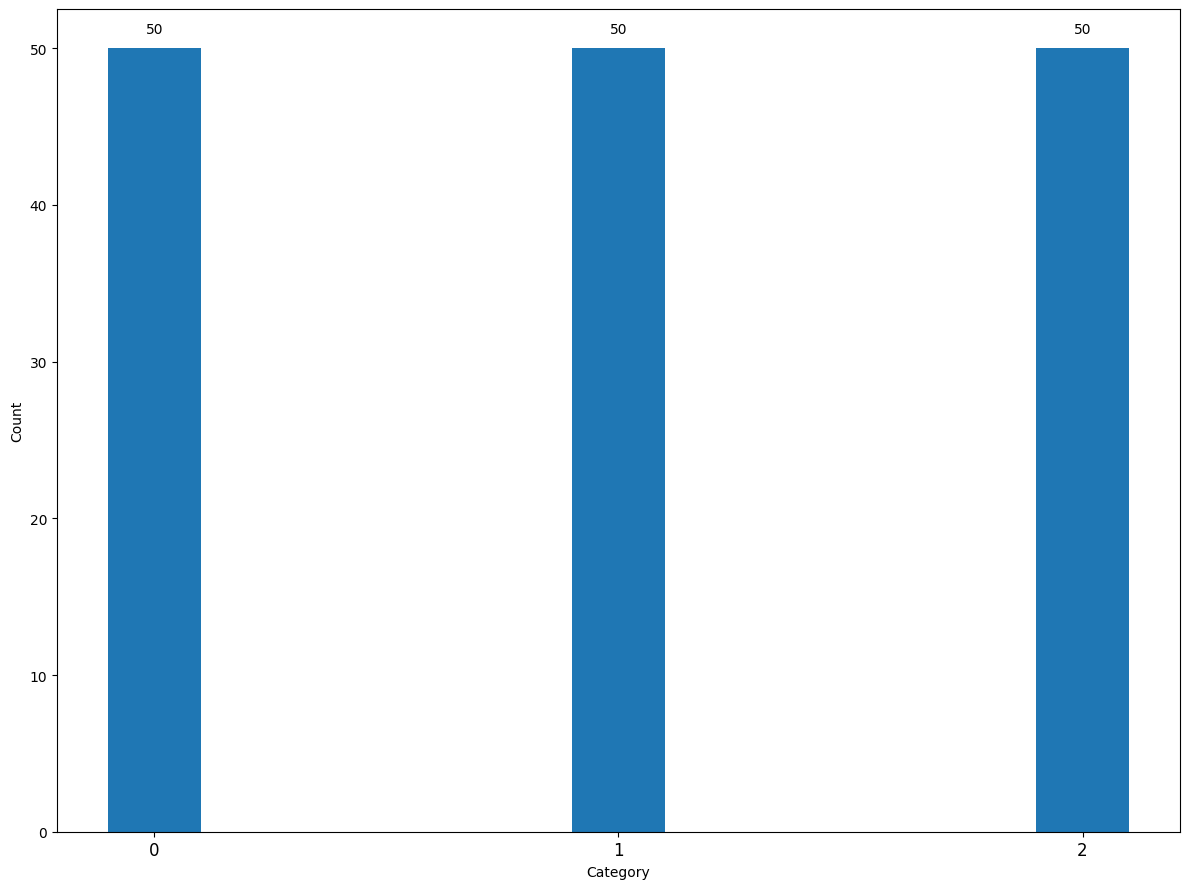

In [8]:
fig, ax = plt.subplots()

x = [0, 1, 2]
y = iris_df['target'].value_counts().sort_index().tolist()

ax.bar(x, y, width=0.2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([0, 1, 2], fontsize=12)

for index, value in enumerate(y):
    plt.text(x=index, y=value+1, s=str(value), ha='center')

plt.tight_layout()

In [9]:
# Train/test split
from sklearn.model_selection import train_test_split

X = iris_df.drop(['target'], axis=1)
y = iris_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)

(105, 4)
(45, 4)


In [11]:
# Baseline model: Gradient Boosting Classifier with all features
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

gbc.fit(X_train, y_train)

preds = gbc.predict(X_test)

f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)

print(f1_score_all)

0.933


In [12]:
# Feature selection techniques
## Variance threshold
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [13]:
X_train_v1.var(axis=0)


,0
sepal length (cm),0.744667
sepal width (cm),0.209035
petal length (cm),3.182842
petal width (cm),0.604582


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

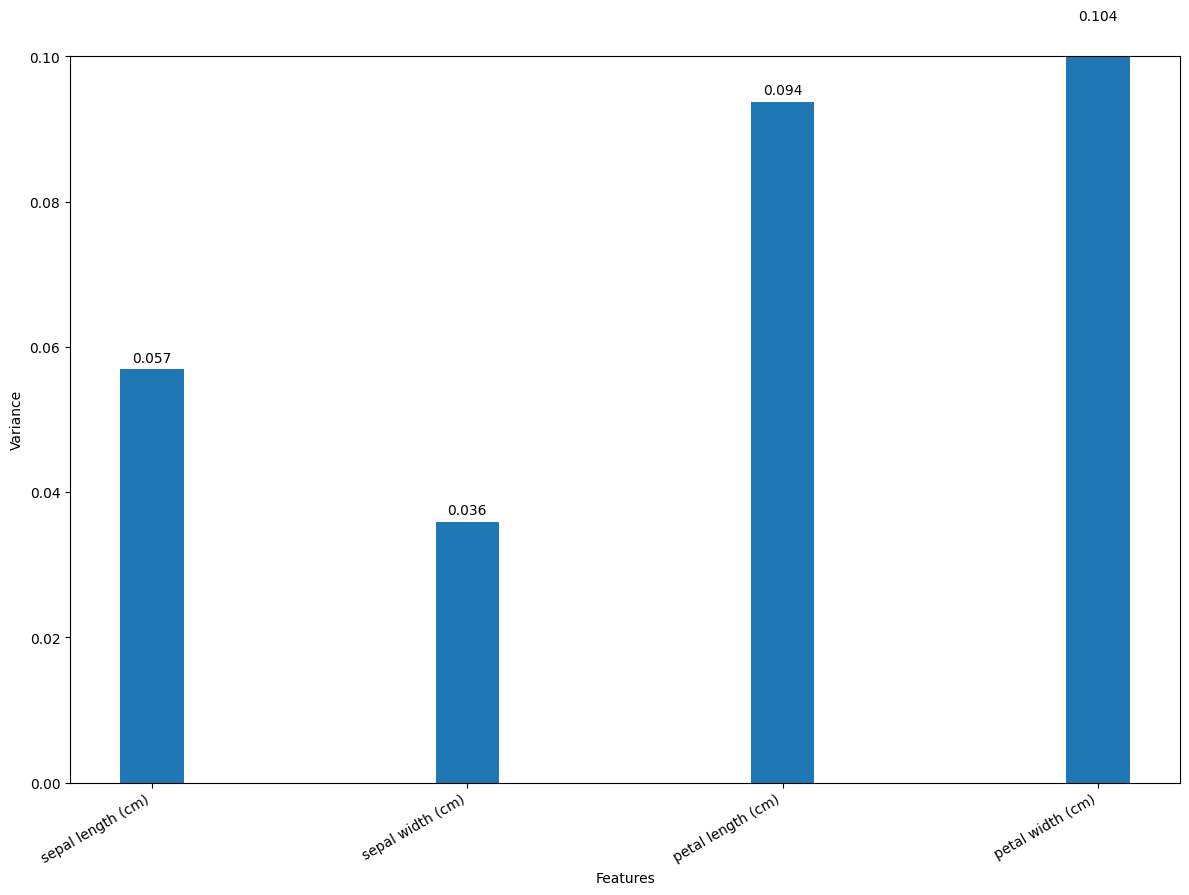

In [15]:
fig, ax = plt.subplots()

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
sel_X_train_v1 = X_train_v1.drop(['sepal width (cm)'], axis=1)
sel_X_test_v1 = X_test_v1.drop(['sepal width (cm)'], axis=1)

gbc.fit(sel_X_train_v1, y_train)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = round(f1_score(y_test_v1, var_preds, average='weighted'), 3)

print(f1_score_var)

0.933


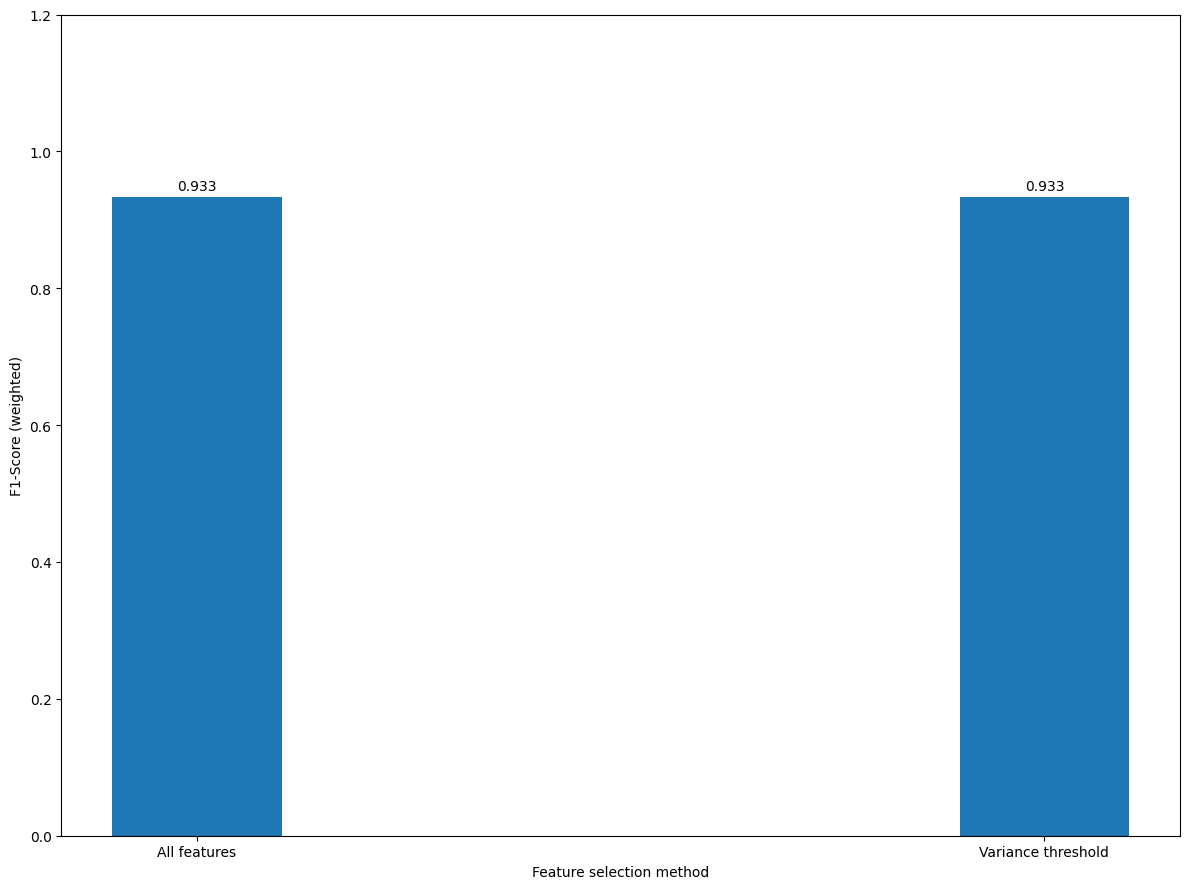

In [17]:
fig, ax = plt.subplots()

x = ['All features', 'Variance threshold']
y = [f1_score_all, f1_score_var]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.01, s=str(round(value, 3)), ha='center')

plt.tight_layout()

In [25]:
## K-best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

f1_score_list = []


for k in range(1, X_train.shape[1] + 1):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    gbc.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = gbc.predict(sel_X_test_v2)

    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds, average='weighted'), 3)
    f1_score_list.append(f1_score_kbest)


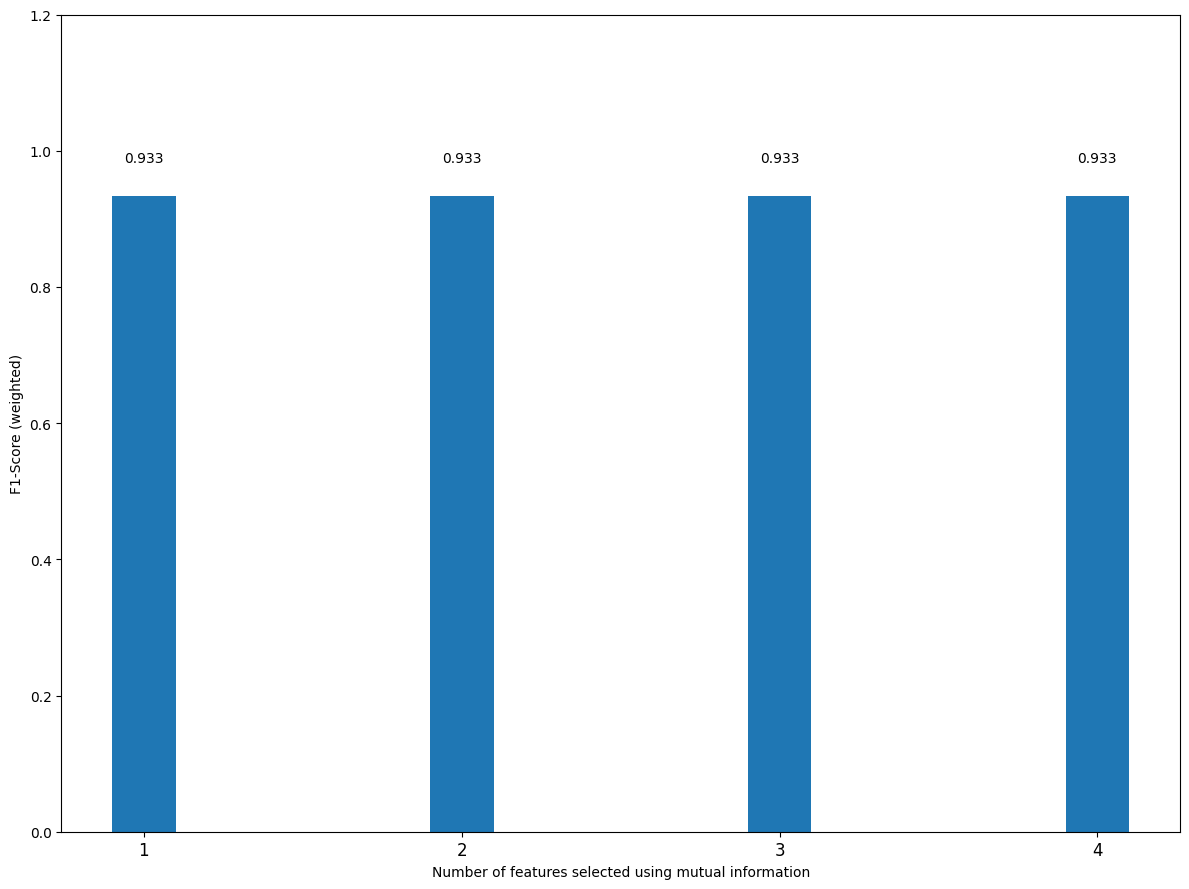

In [26]:
fig, ax = plt.subplots()

x = np.arange(1, 5)
y = f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 5))
ax.set_xticklabels(np.arange(1, 5), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [27]:
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

selected_feature_mask = selector.get_support()

selected_features = X_train.columns[selected_feature_mask]

selected_features

Index(['petal length (cm)', 'petal width (cm)'], dtype='object')

In [28]:
## Recursive feature elimination (RFE)
from sklearn.feature_selection import RFE

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

rfe_f1_score_list = []

for k in range(1, 5):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)

    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)

    gbc.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = gbc.predict(sel_X_test_v3)

    f1_score_rfe = round(f1_score(y_test_v3, RFE_preds, average='weighted'), 3)

    rfe_f1_score_list.append(f1_score_rfe)

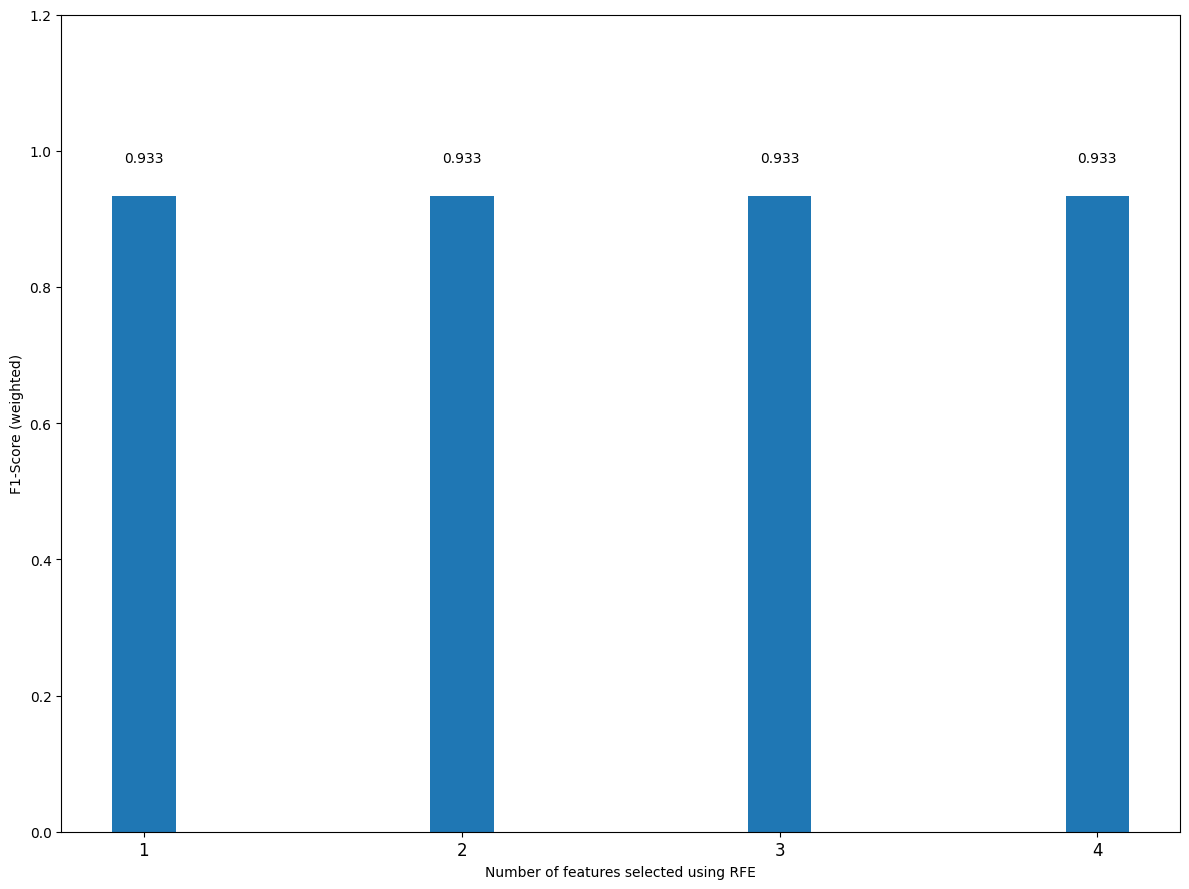

In [29]:
fig, ax = plt.subplots()

x = np.arange(1, 5)
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 5))
ax.set_xticklabels(np.arange(1, 5), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [30]:
RFE_selector = RFE(estimator=gbc, n_features_to_select=2, step=1)
RFE_selector.fit(X_train_v3, y_train_v3)

selected_features_mask = RFE_selector.get_support()

selected_features = X_train.columns[selected_features_mask]

selected_features

Index(['petal length (cm)', 'petal width (cm)'], dtype='object')

In [31]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_v4, y_train_v4)

threshold = 0.02
selector = SelectFromModel(dt, threshold=threshold, prefit=True)
sel_X_train_v4 = selector.transform(X_train_v4)
sel_X_test_v4 = selector.transform(X_test_v4)

gbc.fit(sel_X_train_v4, y_train_v4)
gbc_preds = gbc.predict(sel_X_test_v4)

dt_f1_score = round(f1_score(y_test_v4, gbc_preds, average='weighted'), 3)
print(f"F1 Score with Gradient Boosting Classifier on selected features: {dt_f1_score}")

selected_features_mask = selector.get_support()
selected_features = X_train.columns[selected_features_mask]
print("Selected features:", list(selected_features))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


F1 Score with Gradient Boosting Classifier on selected features: 0.978
Selected features: ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


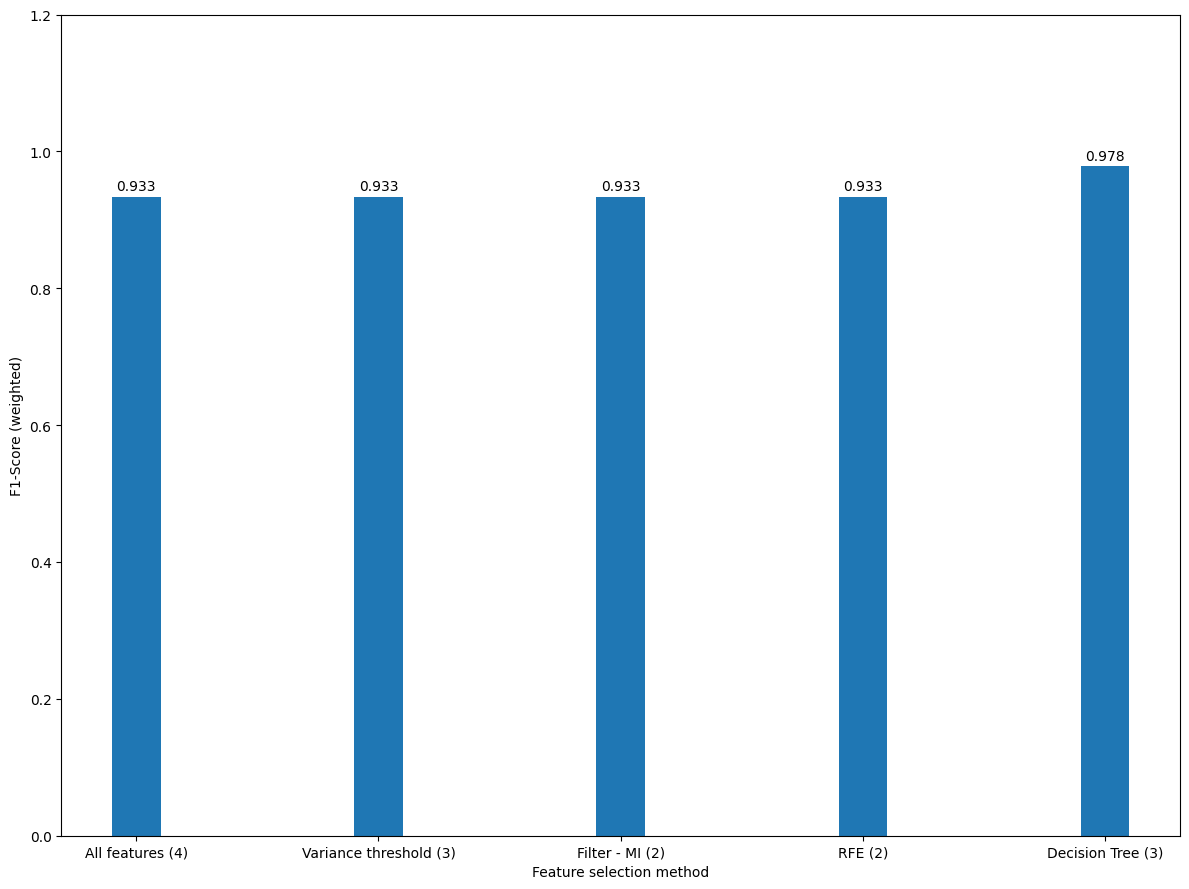

In [32]:

fig, ax = plt.subplots()

x = ['All features (4)', 'Variance threshold (3)', 'Filter - MI (2)', 'RFE (2)', 'Decision Tree (3)']
y = [f1_score_all, f1_score_var, f1_score_list[-1], rfe_f1_score_list[-1], dt_f1_score]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for i, v in enumerate(y):
    plt.text(x=i, y=v+0.01, s=str(v), ha='center')

plt.tight_layout()
